In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn import random_projection, preprocessing, metrics
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.metrics import homogeneity_score
from ucimlrepo import fetch_ucirepo 
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold import MDS
from typing import Tuple
import matlab.engine
np.random.seed(1234)

In [12]:
def load_mines_x_y() -> Tuple[pd.DataFrame, pd.DataFrame]:
    try:
        mines = load_mines_file()
        X = mines.drop(['M'], inplace=False, axis=1)
        y = pd.DataFrame(mines['M'])
        return X, y
    except:
        mines = fetch_ucirepo(id=763) 
        X = mines.data.features 
        y = mines.data.targets
        pd.concat([y['M'], X], axis=1).to_csv('mines.csv', index=False)
    return X, y

def load_mines() -> pd.DataFrame:
    try:
        mines = load_mines_file()
        return mines
    except:
        mines = fetch_ucirepo(id=763) 
        X = mines.data.features 
        y = mines.data.targets 
        df = pd.concat([y['M'], X], axis=1)
        df.to_csv('mines.csv', index=False)
        return df

def load_mines_file(filename='mines.csv'):
    mines = pd.read_csv(filename)
    return mines


load_mines()

,M,V,H,S
0,1,0.338157,0.000000,0.0
1,1,0.320241,0.181818,0.0
2,1,0.287009,0.272727,0.0
3,1,0.256284,0.454545,0.0
4,1,0.262840,0.545455,0.0
...,...,...,...,...
333,5,0.323262,0.909091,0.4
334,5,0.444108,0.181818,1.0
335,5,0.353474,0.454545,1.0
336,5,0.362537,0.727273,1.0


In [13]:
#EM for rice
eng = matlab.engine.start_matlab()
eng.cd('../')

X, y = load_mines_x_y()
X = (X - X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.values.transpose().astype('float64')
em_homogeneity = []
em_silhouette = []
max_llh = []
for k in range(2, 16):
    em = eng.mixGaussEm(X_train, float(k), nargout=3)
    llh = np.array(em[2]).max()
    labels = np.array(em[0])[0]
    homogeneity = homogeneity_score(y_train['M'], labels)
    silhouette = metrics.silhouette_score(X_train.T, labels)
    em_silhouette.append(silhouette)
    em_homogeneity.append(homogeneity)
    max_llh.append([k, llh])


EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 
EM for Gaussian mixture: running ... 


In [15]:
X, y = load_mines_x_y()
X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
spectral_homogeneity = []
spectral_silhouette = []
for n in range(2, 16):
    labels = SpectralClustering(n_clusters=n, random_state=123).fit_predict(X_train)
    spectral_homogeneity.append(homogeneity_score(y_train['M'], labels))
    spectral_silhouette.append(metrics.silhouette_score(X_train, labels))

Text(0, 0.5, 'Score')

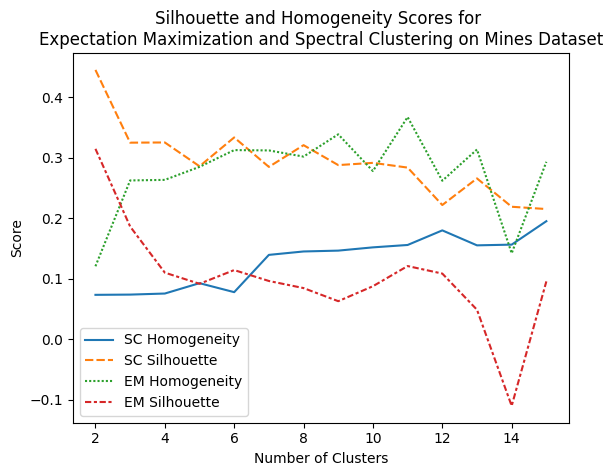

In [18]:
initial_clustering_scores = pd.DataFrame()
initial_clustering_scores['SC Homogeneity'] = spectral_homogeneity
initial_clustering_scores['SC Silhouette'] = spectral_silhouette
initial_clustering_scores['EM Homogeneity'] = em_homogeneity
initial_clustering_scores['EM Silhouette'] = em_silhouette
initial_clustering_scores.index = range(2, 16)
g = sns.lineplot(initial_clustering_scores)
g.legend(fontsize=10)
g.set_title('Silhouette and Homogeneity Scores for \nExpectation Maximization and Spectral Clustering on Mines Dataset')
g.set_xlabel('Number of Clusters')
g.set_ylabel('Score')
#pd.DataFrame([spectral_scores[:, 0], spectral_scores[:, 1], em_scores[:, 0], em_scores[:, 1]], columns=["SC Homogeneity", "SC Silhoutte", "EM Homogeneity", "EM Silhoutte"])

In [ ]:
X, y = load_mines_x_y()